# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
# Load signs nmes
import pickle
import csv

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_file, y_train_file = train['features'], train['labels']
X_valid_file, y_valid_file = valid['features'], valid['labels']
X_test_org, y_test = test['features'], test['labels']


assert(len(X_train_file) == len(y_train_file))
assert(len(X_valid_file) == len(y_valid_file))
assert(len(X_test_org) == len(y_test))


##
## Load the signs names
f = open('signnames.csv')
csv_f = csv.reader(f)
signnames = []
for row in csv_f:
    signnames.append(row[1])
signnames = signnames[1:]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
###  
### Summary of input data
import numpy as np
from scipy import ndimage
import random
from sklearn.utils import shuffle
import cv2
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

###
### Change validation set size if we want. 
### We can use the given validation data, but because it is migth be too small (11%) we can take a bigger validation (20%)
### The default configuration is to stay with the givven validation data (we set change_valid_size_en=0)
change_valid_size_en = 0
if (change_valid_size_en): 
    valid_percentage=20
    n_file_input = len(y_train_file) + len(y_valid_file)
    n_valid = ((valid_percentage*n_file_input)//100)
    n_train = n_file_input-n_valid
    X_train_file, y_train_file = shuffle(X_train_file, y_train_file)

    assert((valid_percentage*n_file_input)//100 > len(y_valid_file))
    X_train_org = X_train_file[0:n_train,:,:,:]
    y_train_org = y_train_file[0:n_train]
    X_valid_org = np.vstack((X_valid_file,X_train_file[n_train:-1]))
    y_valid = np.concatenate((y_valid_file,y_train_file[n_train:-1]))
else:
    X_train_org = X_train_file
    y_train_org = y_train_file
    X_valid_org = X_valid_file
    y_valid = y_valid_file


# Number of train, validation, testing examples.
n_train = len(y_train_org)
n_valid = len(y_valid) 
n_test = len(y_test)

# shape of the traffic sign image?
image_shape = X_train_org[0].shape

# How many unique classes/labels there are in the dataset.
y_all=np.append(y_train_org,y_valid)
n_classes = len(np.unique(y_all))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [3]:
###
### Help functions

### preprocess: 
###   Input: Get 4D array of RGB pictures 
###
###   Transform it to a gray sacle pictures (3D array)
###   From each picture we normalize it by:
###       a) subtracting the mean
###       b) dividing by the difference between the max and the min values
###   
###   Output: 4D array of pictures, the last dimension is 1 (gray scale)
def preprocess(img_in):
    depth=img_in.shape[0]
    size=img_in.shape[1]
    
    ## move to gray scale
    img = img_in[:,:,:,0]*0.2989 + img_in[:,:,:,1]*0.5870 + img_in[:,:,:,2]*0.1140
    
    ## normalize
    img_mean = img.mean(axis=1).mean(axis=1)
    img_min = img.min(axis=1).min(axis=1)
    img_max = img.max(axis=1).max(axis=1)
    
    corr = np.zeros(shape=(depth,1,1))
    corr[:,0,0]=img_mean
    corr = np.tile(corr, (1,size,size))
    img = (img-corr)
    
    corr = np.zeros(shape=(depth,1,1))
    corr[:,0,0]=(img_max-img_min)
    corr = np.tile(corr, (1,size,size))
    img = img/corr
    
    img = np.expand_dims(img,3)
    return img

### get_fake_data: 
###   Input: Get 2D image (gray scale) 
###
###   Transform it by:
###       a) rotate it be a random degrees between (-10 to 10)
###       b) zoom it be a random factor between (0.95 to 1.05)
###       c) shift it be a random number of pixels in each axis between (-2 to 2)
###   
###   Output: 2D image
def get_fake_data(img_in):
    rot = random.randint(-10, 10)
    rsz = random.uniform(0.95, 1.05)
    shx = random.randint(-2,2)
    shy = random.randint(-2,2)
    
    (h, w) = img_in.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, rot, rsz)
    img = cv2.warpAffine(img_in, M, (w, h))
    
    img=ndimage.interpolation.shift(img,[shy,shx],mode='nearest')
    return img


### plot_histo: 
###   Plot histogram according to the hist and bins 
def plot_histo(hist, bins):
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.figure()
    plt.bar(center, hist, align='center', width=width)
    plt.show() 

### Balance the training data and Generate fake data

Sign Index =  17 :  No entry
Original image      -->  After Preprocess-->  After adding jitter


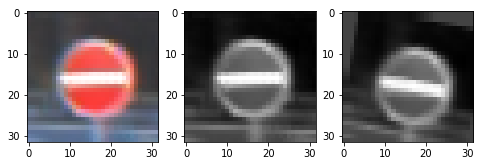

In [4]:
###
### Data exploration visualization code goes here.
index = random.randint(0, len(X_train_org))
image = X_train_org[index]
image = np.expand_dims(image,0)
image_after_pp = preprocess(image)
image_after_pp_fake = get_fake_data(image_after_pp.squeeze())

plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(image.squeeze())
plt.subplot(1,3,2)
plt.imshow(image_after_pp.squeeze(), 'gray')
plt.subplot(1,3,3)
plt.imshow(image_after_pp_fake, 'gray')
print("Sign Index = ",y_train_org[index],": ",signnames[y_train_org[index]])
print("Original image      -->  After Preprocess-->  After adding jitter")


### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Original number of training examples = 34799
Distribution Of original Training Data:


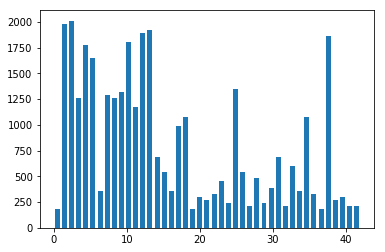

Number of training examples after balancing = 77397
Distribution after balancing the Training Data:


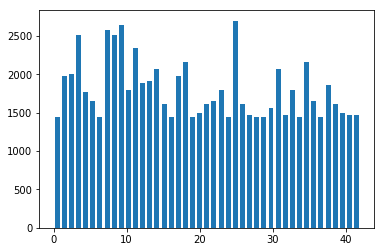

Number of training examples after generating fake data = 154794


In [5]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

###
### Configuration:
###   a) use_a_priory_dist: {0,1} -  If we assume that there is an a-priori distribution for the inputs. If we enable it we will take the 
###      pdf estimation into account in the cross entropy calculation
###   b) balance_en: {0,1} - If we want to balance the input samples in the training set
###   c) add_fake_data_en: {0,1} - if we want to add some "fake" input samples
use_a_priory_dist = 1
balance_en        = 1
add_fake_data_en  = 1 

###
### Extracting the input distribution 
hist, bins = np.histogram(y_train_org, bins=n_classes)
if (use_a_priory_dist==1):
    a_priory_correct = np.log(hist/np.sum(hist))
else:
    a_priory_correct = np.zeros(shape=hist.shape)

### 
### Plotting the original histogram
print("Original number of training examples =", n_train)
print("Distribution Of original Training Data:")
plot_histo(hist, bins)

###  
### Preparring the training data
###   a) Preprocessing: gray scale + normalization
###   b) balancing the data
###   c) Generate fake data

###
### gray scale + normalization
n_colors = 1 # we use gray sacle
X_train_pp = preprocess(X_train_org)
X_valid = preprocess(X_valid_org)
X_test = preprocess(X_test_org)
y_train_pp = y_train_org
 

###
### balancing the data. - each class will have at least "class_minimal_val" samples
### - "class_minimal_val" is set to be the value of the average+std of the original samples
### - For each class we calculate by what factor we have multiply each sample from this class.
### - Each new sample is also jitterred from the original sample (rotation+zoom+shift)
class_minimal_val = 0
if (balance_en):
    class_minimal_val = hist.mean()+hist.std()
    
balance_per_class = class_minimal_val-hist
balance_per_inst = np.ceil(balance_per_class/hist)
balance_per_inst = balance_per_inst.clip(min=0.0).astype(int)
n_train_bal = n_train + (balance_per_inst*hist).sum()

X_train_bal =np.zeros(shape=(n_train_bal,image_shape[0],image_shape[1],1))
y_train_bal = np.zeros(shape=(n_train_bal))

X_train_bal[0:n_train,] = X_train_pp
y_train_bal[0:n_train] = y_train_pp

pad_position=0
for i in range(n_train):
    for k in range(balance_per_inst[y_train_pp[i]]):
        X_train_bal[n_train+pad_position,:,:,0] = get_fake_data(X_train_pp[i])
        y_train_bal[n_train+pad_position] = y_train_pp[i]
        pad_position+=1

print("Number of training examples after balancing =", n_train_bal)
print("Distribution after balancing the Training Data:")

### 
### Plotting the "balanced" histogram
hist_bal, bin_bal = np.histogram(y_train_bal, bins=n_classes)
plot_histo(hist_bal, bin_bal)


###
### Generate fake data - "factor" select by what factor we will increase the number of input sample
###  - We set "facor" to 2 as default
###  - We keep the same distribution
### - Each new sample is also jitterred from the original sample (rotation+zoom+shift)
factor = 1 
if (add_fake_data_en):
    factor = 2
    
X_train = np.zeros(shape=(factor*n_train_bal,image_shape[0],image_shape[1],1))
y_train = np.zeros(shape=factor*y_train_bal.shape[0])

X_train[0:n_train_bal,] = X_train_bal
y_train[0:n_train_bal] = y_train_bal

for i in range((factor-1)*n_train):
    X_train[n_train+i,:,:,0] = get_fake_data(X_train[i%n_train])
    y_train[n_train+i]=y_train_org[i%n_train]

print("Number of training examples after generating fake data =", y_train.shape[0])
      
###
### shuffle the data
X_train, y_train = shuffle(X_train, y_train)

# Model Architecture (LeNet)

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
__VER = int(tf.__version__[0])

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32xn_colors. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, n_colors, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)
    stg_1 = conv1

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    stg_2 = conv2

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # We bypass from conv1
    # Input 14x14x6 --> 7x7x6. Output = 294
    conv1_bp = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1_bp = flatten(conv1_bp)
    
    if (__VER==1):
        fc0 = tf.concat([fc0,conv1_bp],1)  # ver 1.x
    else:
        fc0 = tf.concat(1, [fc0,conv1_bp]) # ver 0.x
    
    # Layer 3: Fully Connected. Input = 400+294. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(694, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1,0.8)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2,0.8)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes (43).
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return [logits, stg_1, stg_2]

### Train, Validate and Test the Model

In [7]:
### hyperparameters
EPOCHS = 15
BATCH_SIZE = 128
LEARN_RATE_GEAR_1 = 0.001
LEARN_RATE_GEAR_2 = 0.0001
SHIFT_GEAR = 10

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### PlaceHolders & Pipeline

In [8]:
###
### PlaceHolders
x = tf.placeholder(tf.float32, (None, 32, 32, n_colors))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
apriori = tf.placeholder(tf.float32, (None))
rate = tf.placeholder(tf.float32)

w_stg1 = tf.placeholder(tf.float32, (None, None, None, None))
w_stg2 = tf.placeholder(tf.float32, (None, None, None, None))

###
### Main Pipeline
logits, w_stg1, w_stg2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=tf.add(logits,apriori))
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

###
### Get top 5 probabilities 
TopKV2 = tf.nn.top_k(tf.add(logits,apriori), k=5)  

### Evaluation

In [9]:
###
### evaluate - evaluate the error. each miss identification has the same weight 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### evaluate: 
###   Input: X_data - the input data,  y_data - the correct sign index
###   Output: fraction of correct estimation
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


### get_most_likely: 
###   Input: X_data - the input data
###   Output: topK - top (5) logits and thier matching sign indexes
def get_most_likely(X_data):
    sess = tf.get_default_session()
    topK = sess.run(TopKV2, feed_dict={x: X_data, apriori: a_priory_correct})
    return topK
    

### Training

In [10]:
###
### Train the model with the train data and evaluate on the validation data.
### We save the model once we finish
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    learn_rate=LEARN_RATE_GEAR_1
    print("Training...")
    print()
    for i in range(EPOCHS):
        if (i>=SHIFT_GEAR):
            learn_rate=LEARN_RATE_GEAR_2
            if (i==SHIFT_GEAR):
                print("              Shift Gear")
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, apriori: a_priory_correct, rate: learn_rate})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        train_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f} ; Train Accuracy = {:.3f}".format(validation_accuracy,train_accuracy))
        print()
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f} ".format(test_accuracy))
    
    saver.save(sess, './lenet_tarfic_sign_classifier')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.791 ; Train Accuracy = 0.894

EPOCH 2 ...
Validation Accuracy = 0.887 ; Train Accuracy = 0.942

EPOCH 3 ...
Validation Accuracy = 0.913 ; Train Accuracy = 0.964

EPOCH 4 ...
Validation Accuracy = 0.927 ; Train Accuracy = 0.970

EPOCH 5 ...
Validation Accuracy = 0.929 ; Train Accuracy = 0.974

EPOCH 6 ...
Validation Accuracy = 0.937 ; Train Accuracy = 0.980

EPOCH 7 ...
Validation Accuracy = 0.933 ; Train Accuracy = 0.980

EPOCH 8 ...
Validation Accuracy = 0.946 ; Train Accuracy = 0.981

EPOCH 9 ...
Validation Accuracy = 0.940 ; Train Accuracy = 0.982

EPOCH 10 ...
Validation Accuracy = 0.945 ; Train Accuracy = 0.986

              Shift Gear
EPOCH 11 ...
Validation Accuracy = 0.957 ; Train Accuracy = 0.991

EPOCH 12 ...
Validation Accuracy = 0.959 ; Train Accuracy = 0.991

EPOCH 13 ...
Validation Accuracy = 0.956 ; Train Accuracy = 0.992

EPOCH 14 ...
Validation Accuracy = 0.961 ; Train Accuracy = 0.992

EPOCH 15 ...
Validation Accuracy 

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Sign_0) Index=#4 : Speed limit (70km/h)
Sign_1) Index=#9 : No passing
Sign_2) Index=#11: Right-of-way at the next intersection
Sign_3) Index=#12: Priority road
Sign_4) Index=#14: Stop
Sign_5) Index=#32: End of all speed and passing limits


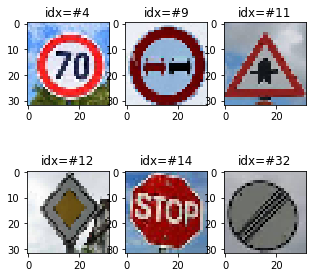

In [11]:
###
# 1) Load the images, 
# 2) change thier size to 32x32x3
# 3) Plot them with thier sign number
# 4) preprocess.
###

img_size = 32.0               # We need pictures that are 32x32
y_new_img = [4,9,11,12,14,32]   # We correct signs indexes of the pictures
n_new_img = len(y_new_img)    # We have 6 pictures

###
### Collect the 5 pictures to 1 4D array (5x32x32x3)
### Plot each picture with the sign index
X_new_img_org = np.zeros(shape=(n_new_img,int(img_size),int(img_size),3))
plt.figure(figsize=(5,5))
for i in range(n_new_img):
    X = cv2.imread("sign_" +str(y_new_img[i])+ ".jpg")
    X = cv2.resize(X , None, fx=(img_size / X.shape[1]), fy=(img_size / X.shape[0]), interpolation=cv2.INTER_CUBIC)
    plt.subplot(2,3,i+1) 
    plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
    plt.title("idx=#"+str(y_new_img[i]))
    print("Sign_{}) Index=#{:<2d}: {}".format(i,y_new_img[i],signnames[y_new_img[i]]))
    X_new_img_org[i,:,:,:]=X


# Predict the Sign Type for Each Image

In [12]:
###
### pre-processing
X_new_img = preprocess(X_new_img_org)

###
### restore the CNN and get the top 5 logits and thier matching sign indexes
with tf.Session() as sess:
    saver.restore(sess, "./lenet_tarfic_sign_classifier")
    print("Model restored.")
    print()
    topK_mat = get_most_likely(X_new_img)


### 
### Analyze Performance
### Calculate the accuracy for these 5 new images. 
total_cor = ((topK_mat.indices[:,0]==y_new_img).sum())
print("Total Correct Img = {}/{} = {:.2f}%".format(total_cor,n_new_img,total_cor*100/n_new_img))


###
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### the softmax probabilities will take into account the a-priopri probabilties according to our configuration ("a_priory_correct")
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

for i in range(n_new_img):
    softmax_vec = softmax(topK_mat.values[i,:])
    print("   Softmax For Sign: ",signnames[y_new_img[i]])
    for j in range(5):
        print('      Sign={:<52} with Pr={:.2e}'.format(signnames[topK_mat.indices[i,j]], softmax_vec[j]))
    print()

Model restored.

Total Correct Img = 5/6 = 83.33%
   Softmax For Sign:  Speed limit (70km/h)
      Sign=Speed limit (20km/h)                                 with Pr=9.52e-01
      Sign=Speed limit (70km/h)                                 with Pr=4.78e-02
      Sign=Road narrows on the right                            with Pr=5.19e-06
      Sign=Keep left                                            with Pr=4.49e-06
      Sign=Traffic signals                                      with Pr=3.29e-06

   Softmax For Sign:  No passing
      Sign=No passing                                           with Pr=1.00e+00
      Sign=End of no passing                                    with Pr=2.85e-06
      Sign=Stop                                                 with Pr=2.37e-09
      Sign=End of all speed and passing limits                  with Pr=8.05e-10
      Sign=No entry                                             with Pr=1.44e-11

   Softmax For Sign:  Right-of-way at the next intersection
  

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [13]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

Model restored.

Feature Map Stage 1:


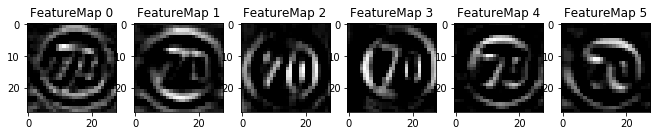

In [14]:
with tf.Session() as sess:
    saver.restore(sess, "./lenet_tarfic_sign_classifier")
    print("Model restored.")
    
    print()
    print("Feature Map Stage 1:")
    outputFeatureMap(X_new_img, w_stg1, plt_num=1)


Model restored.

Feature Map Stage 2:


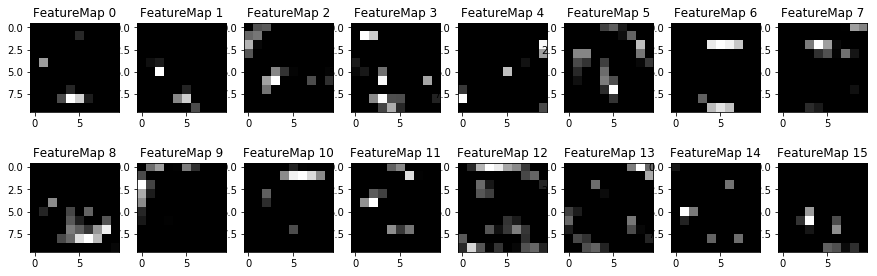

In [15]:
with tf.Session() as sess:
    saver.restore(sess, "./lenet_tarfic_sign_classifier")
    print("Model restored.")
    
    print()
    print("Feature Map Stage 2:")
    outputFeatureMap(X_new_img, w_stg2, plt_num=2)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**
We plotted the visual output after the first two satges of the "Speed limit (70km/h)" sign. We can see nicly after the first stage clear characteristics, for example the circle and the "70".
From the 2ed stage it is more difficult to see somthing clear.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 